# Parameters & Optimisation
In this tutorial, parameters are introduced within a circuit and used to quickly adjust values within it as part of an optimisation.

In [1]:
import lightworks as lw

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

First, the parameterized circuit is created. This is a Reck interferometer, which has a triangular shape, and should be capable of implementing any unitary matrix across its modes. 

Each unit cell of the interferometer contains an external phase shift and a Mach-Zehnder interferometer, comprised of two 50:50 beam splitters with a phase shift between them. For each of the unit cells, a theta and phi parameter are created and added to the dictionary, these are then assigned to the corresponding phase shift elements. All parameters are configured with bounds of $0-2\pi$ and labels are assigned which are utilized when displaying the circuit.

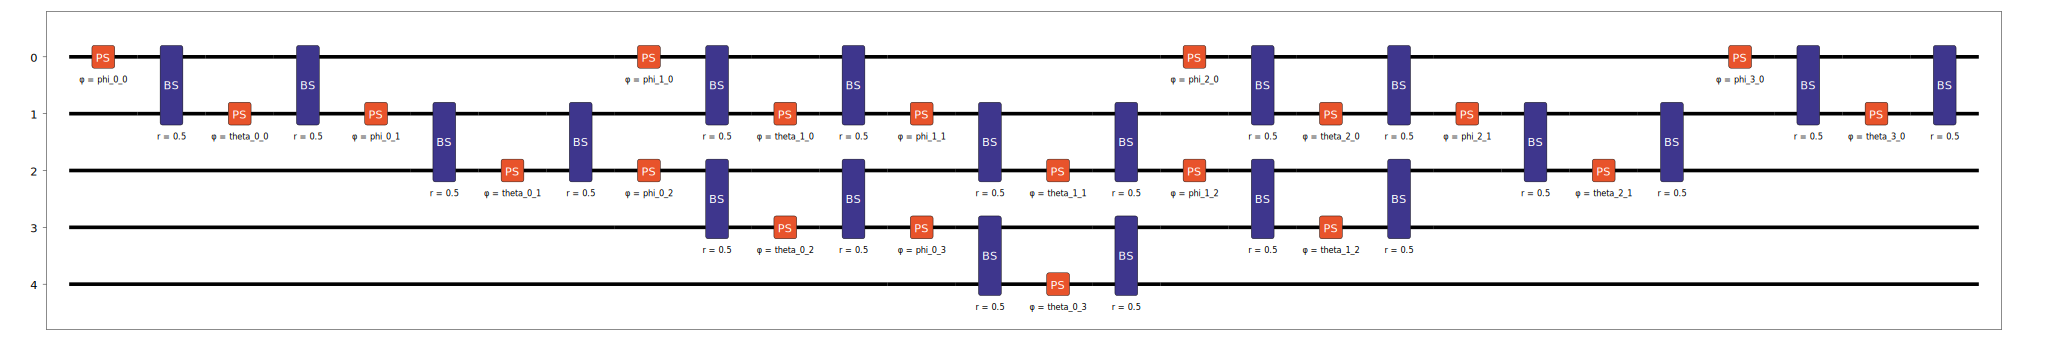

In [2]:
# Create new circuit
n_modes = 5
reck = lw.Circuit(n_modes)

# For storing parameters
pdict = lw.ParameterDict()

for i in range(n_modes-1):
    for j in range(0, n_modes-1-i, 1):
        reck.add_barrier([j, j+1]) # Use barrier to separate unit cells
        
        # Create new parameters for theta and phi
        theta, phi = f"theta_{i}_{j}", f"phi_{i}_{j}"
        pdict[theta] = lw.Parameter(0, bounds = [0, 2*np.pi], label = theta)
        pdict[phi] = lw.Parameter(0, bounds = [0, 2*np.pi], label = phi)
        # Then add parameterized components to cicuit
        reck.add_ps(j, pdict[phi])
        reck.add_bs(j)
        reck.add_ps(j+1, pdict[theta])
        reck.add_bs(j)
        
reck.display()

## Optimisation

To demonstrate circuit parameterization, we will configure an optimisation in which a random unitary matrix is generated and the parameters of the circuit then modified to implement this unitary as closely as possible. This would traditionally be achieved by a unitary decomposition procedure, but there may be some cases in which this is not possible and a process as below would be more suitable, such as in high error rate circuit.

For the optimisation, we define a fom function, which updates the circuit parameters with the determined values and then finds the fidelity of the implemented unitary with the target unitary matrix. In this case we choose the fidelity to be defined as

$$\text{F} = \frac{1}{N}\text{Tr}(|U_t|\cdot|U|),$$

where N is the number of modes, $U_t$ is the target unitary and $U$ is the implemented unitary.

A callback function is also defined for the purpose of tracking the evolution of the figure of merit.

In [3]:
def get_fidelity(U, target_U):
    """Finds fidelity between implemented and target unitary."""
    N = U.shape[0]
    return 1/N * np.trace(abs(np.conj(target_U.T))@abs(U))

def fom(params, circuit, pdict, target_U):
    """Updates parameters and returns figure of merit for the optimisation."""
    # Update parameter dictionary with the optimisation values
    for i, param in enumerate(pdict):
        pdict[param] = params[i]
    U = circuit.U # Get unitary matrix implemented by the circuit
    return -get_fidelity(U, target_U) # Must be negative as we are minimizing

def callback(params):
    """
    Define callback function to be able to track the progress of the fom after 
    each iteration. This can only accept the params argument, meaning all other
    components required to save the fom need to be included through using the
    global operator.
    """
    global opt_progress, reck, pdict, target_U
    opt_progress.append(-fom(params, reck, pdict, target_U))

The optimisation can then be configured, in this case the SciPy minimize function is chosen. The initial values are set to all be $\pi/2$, and for the bounds, we use the get_bounds method of the parameter dictionary to recover the bounds set on creation of each parameter.

The optimisation is then run, using the provided callback function to store progress data.

In [4]:
# Generate random unitary to implement
target_U = lw.random_unitary(n_modes, seed = 99)

# Set initial values as pi/2
init_values = [np.pi/2]*len(pdict)
# Retrieve bounds from the parameter dictionary
bounds = list(pdict.get_bounds().values())

opt_progress = [] # Store fom values
res = minimize(fom, init_values, args = (reck, pdict, target_U), 
               bounds = bounds, callback = callback)

### Results
Once the optimization is complete we can view the value of the figure of merit after each iteration. As can be seen, using the fidelity measurement defined above we are able to near perfectly implement the transformation on chip.

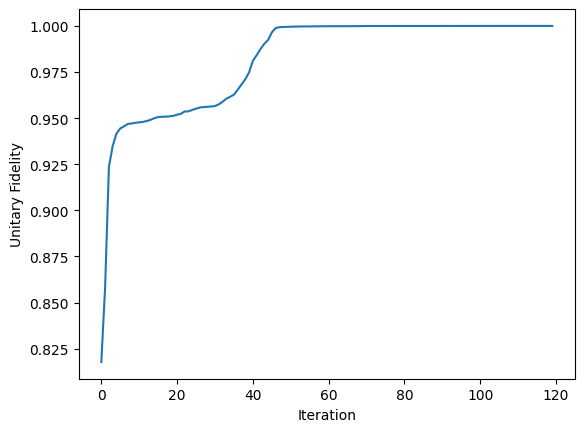

In [5]:
plt.plot(opt_progress)
plt.xlabel("Iteration")
plt.ylabel("Unitary Fidelity")
plt.show()

The final configuration of the circuit can also be displayed, using the show_parameter_values option to see the actual phase settings.

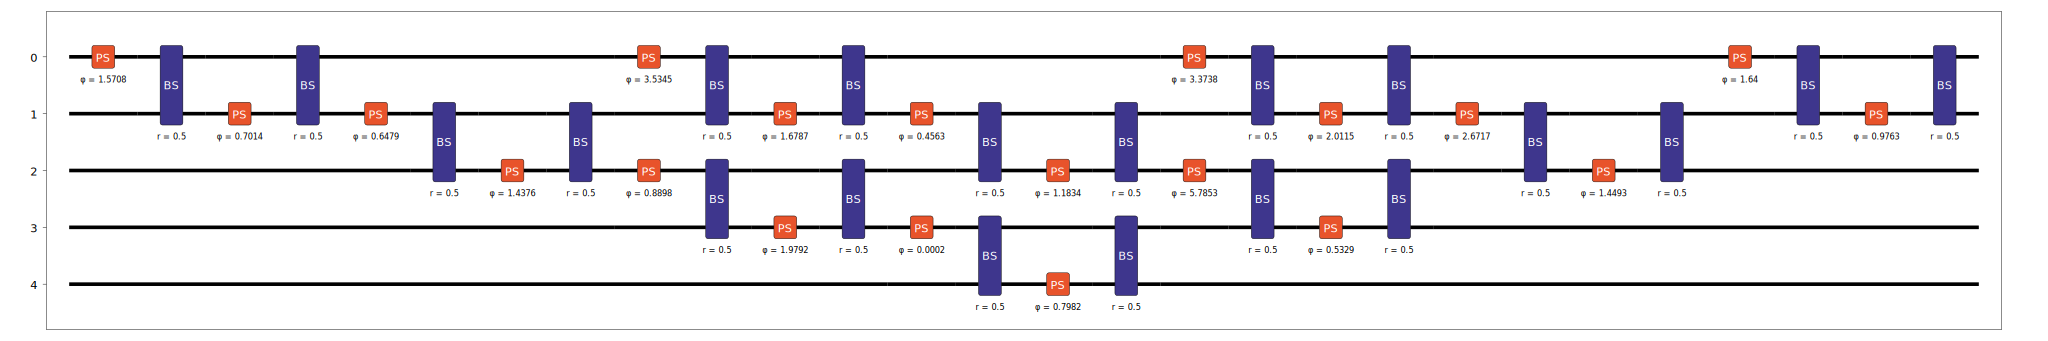

In [6]:
# Configure circuit to optimal configuration
for i, param in enumerate(pdict):
    pdict[param] = res.x[i]
    
reck.display(show_parameter_values = True)

And finally, we can plot the target and implemented unitary side by side to check they are visually equivalent.

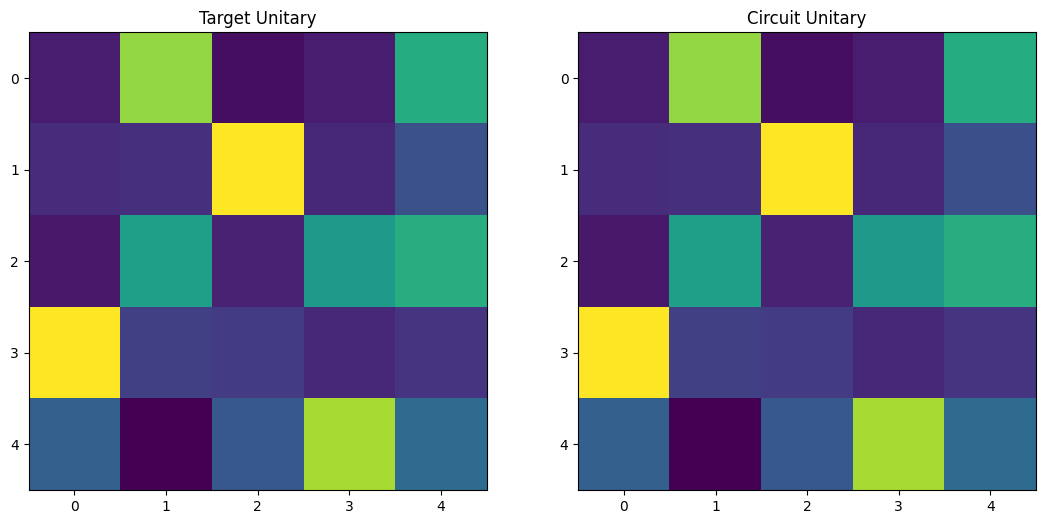

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (13, 6))

ax[0].imshow(abs(target_U))
ax[0].set_title("Target Unitary")

ax[1].imshow(abs(reck.U))
ax[1].set_title("Circuit Unitary")

plt.show()